# Tests on both databases to identify necessary mashup operations

### Imports

In [1]:
import os
from datetime import datetime
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import csv
import re

### FUNCTION : Transform JSON SPARQLWrapper results into a pandas.DataFrame object

In [2]:
def query_to_df(spql_queried):
    
    preparing = {}
    
    try:
        spql_return = spql_queried.queryAndConvert()
        
        for ret in spql_return["results"]["bindings"]:
            for var in ret.keys():
                if var not in preparing.keys():
                    preparing[var] = []
                    
        for ret in spql_return["results"]["bindings"]:
            for var in preparing.keys():
                if var in ret.keys():
                    preparing[var].append(ret[var]['value'])
                else:
                    preparing[var].append('None')
        return pd.DataFrame(preparing)

    except Exception as e:
        print("The query has a problem. Here is the error:\n\t", e)

### FUNCTION : Sum up informations in column

In [3]:
def sum_it_up(df, filename, fieldname):
    try:
        name_strs = []

        for name in np.unique(df[fieldname]):
            name_strs.append({'name': name, 'appear that often':operator.countOf(df[fieldname], name)})


        occ_nb = pd.DataFrame.from_dict(name_strs)
        nb_stats = pd.DataFrame(occ_nb['appear that often'].value_counts())
        nb_stats = nb_stats.reset_index()
        nb_stats.columns = ['appear that often', f'how many distinct [{fieldname}]']
        nb_stats['appear that often'].astype(str)
        nb_stats = nb_stats[nb_stats.columns[::-1]]

        print(f'Il y a {len(df)} lignes au tableau {filename}, avec {len(name_strs)} "{fieldname}" différents. Voici combien de fois chacun apparaît :')
        display(occ_nb)
        print("Extrait du tableau source du diagramme :")
        display(nb_stats.head(3))
        nb_stats.plot.bar(x = 'appear that often', legend = False, title = f'Distribution du nombre d\'apparitions des [{fieldname}] dans {filename}.', xlabel = 'Nombre d\'apparitions par nom distinct.', ylabel = f'Nombre de [{fieldname}] distincts.')
        print(f"Comment lire ce diagramme : {nb_stats.iloc[0][f'how many distinct [{fieldname}]']} [{fieldname}] sont présents {nb_stats.iloc[0]['appear that often']} fois.")

        return occ_nb
    
    except Exception as e:
        print(f"Cette colonne de {filename} m'est étrange :\t{fieldname}.")
        print(e)

# SLAVE VOYAGES

In [4]:
# Import des données.

sv_orig = pd.read_csv(
    "../../1-dataviz_tools/netherlands.csv",
    skip_blank_lines=False,
    infer_datetime_format = True,
    na_filter=False
)

# Contrôle des variables disponibles.

for header in list(sv_orig):
    print(header)
    
# Contrôle des 10 premières lignes.

sv_orig.head(10)

Flag of vessel
Date vessel departed with captives
Vessel name
Captain's name


,Flag of vessel,Date vessel departed with captives,Vessel name,Captain's name
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter"
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der"
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof"
3,Netherlands,,Wapen van Amsterdam,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter"
5,Netherlands,1700-12-15T00:00:00Z,Wapen van Holland (a) Hollandia,"Stoop, Pieter"
6,Netherlands,1700-12-15T00:00:00Z,Wapen van Holland (a) Hollandia,"Crans, Pieter"
7,Netherlands,,Wapen van Holland (a) Hollandia,"Crans, Pieter"
8,Netherlands,,Wapen van Holland (a) Hollandia,"Leijm, Lodewijk van der"
9,Netherlands,1686-02-14T00:00:00Z,Wapen van Zierikzee,"Banckert, Joost"


Il y a 1909 lignes au tableau Slave Voyages, avec 930 "Captain's name" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,,196
1,"Adriaanse, Adriaan (?)",1
2,"Adriaansen, Joris",3
3,"Adriaansen, Pieter",1
4,"Adriaansen, Wylof",1
...,...,...
925,"Zeerat, Thomas Jansz",1
926,"Zeerat, Thomas van",1
927,"Zegert, Hans van",1
928,"Zell, Georg Christoff",3


Extrait du tableau source du diagramme :


,how many distinct [Captain's name],appear that often
0,619,1
1,109,2
2,88,3


Comment lire ce diagramme : 619 [Captain's name] sont présents 1 fois.


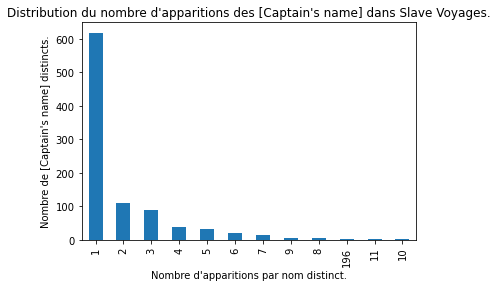

In [5]:
sv_p = sum_it_up(sv_orig, "Slave Voyages", "Captain's name")

Il y a 1909 lignes au tableau Slave Voyages, avec 643 "Vessel name" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,,44
1,'s-Graveland,2
2,Aartshertogin Maria Christina,1
3,Abrahams Offerhand,3
4,Abrahams Offerhand (a) Sacrificio de A,2
...,...,...
638,Zwarte Arend,7
639,Zwarte Arend (a) Aguila,1
640,Zwarte Beer,1
641,Zwarte Dubbele Arend,1


Extrait du tableau source du diagramme :


,how many distinct [Vessel name],appear that often
0,298,1
1,115,2
2,68,3


Comment lire ce diagramme : 298 [Vessel name] sont présents 1 fois.


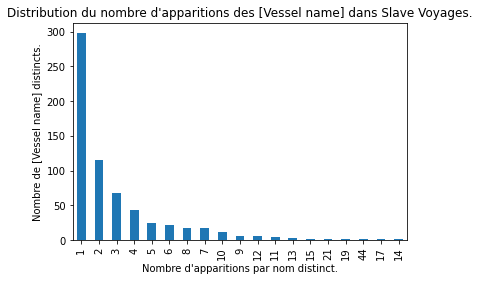

In [6]:
sv_v = sum_it_up(sv_orig, "Slave Voyages", "Vessel name")

# MARITIME HISTORY

### General definitions

In [7]:
mh_endpoint = SPARQLWrapper("https://sparql.geovistory.org/api_v1_project_84760")
mh_endpoint.setReturnFormat(JSON)
mh_prefixes = """
    PREFIX onto: <http://www.ontotext.com/>
    PREFIX ont: <http://purl.org/net/ns/ontology-annot#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX xml: <http://www.w3.org/XML/1998/namespace>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    PREFIX time: <http://www.w3.org/2006/time#>
    PREFIX ontome: <https://ontome.net/ontology/>
    PREFIX geov: <http://geovistory.org/resource/>
"""

### Get people, then ship informations

In [8]:
mh_endpoint.setQuery(mh_prefixes + """
    SELECT ?person ?persname
    WHERE {
    ?person rdf:type ontome:c21 ;
        rdfs:label ?persname.
    }
""")

mh_people = query_to_df(mh_endpoint)

In [9]:
mh_endpoint.setQuery(mh_prefixes + """
    SELECT ?ship ?ship_name
    WHERE {
    ?ship rdf:type ontome:c522 ;
        rdfs:label ?ship_name.
    }
""")

mh_ships = query_to_df(mh_endpoint)

### People in Maritime History

Voici les résultats de la requête surles personnes dans Maritime History :


,person,persname
0,http://geovistory.org/resource/i86212,Jan Ravensbergh
1,http://geovistory.org/resource/i86217,Andries Liens
2,http://geovistory.org/resource/i88304,Abraham Staelboom
3,http://geovistory.org/resource/i87834,Abraham Franke
4,http://geovistory.org/resource/i89995,Jan Pietersz
...,...,...
7609,http://geovistory.org/resource/i92412,Andries Hermanus Meijer
7610,http://geovistory.org/resource/i85632,Thimon Toelanger
7611,http://geovistory.org/resource/i90583,Anthonij Westerbeek
7612,http://geovistory.org/resource/i91035,Willem de Raad


Il y a 7614 lignes au tableau Maritime History, avec 7614 "person" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,http://geovistory.org/resource/i84852,1
1,http://geovistory.org/resource/i84853,1
2,http://geovistory.org/resource/i84854,1
3,http://geovistory.org/resource/i84855,1
4,http://geovistory.org/resource/i84856,1
...,...,...
7609,http://geovistory.org/resource/i92461,1
7610,http://geovistory.org/resource/i92462,1
7611,http://geovistory.org/resource/i92463,1
7612,http://geovistory.org/resource/i92464,1


Extrait du tableau source du diagramme :


,how many distinct [person],appear that often
0,7614,1


Comment lire ce diagramme : 7614 [person] sont présents 1 fois.
Il y a 7614 lignes au tableau Maritime History, avec 7346 "persname" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,Aard Aardse,1
1,Aarianus van Lotthum,1
2,Aarnoldus de Schoone,1
3,Aarnoud Pietersz,1
4,Aarnout Cornelis Ooremans,1
...,...,...
7341,Zacharias Kok,1
7342,Zacharias Lourensz,1
7343,Zacharias Nochel,1
7344,Zacharias Zachariasz.,1


Extrait du tableau source du diagramme :


,how many distinct [persname],appear that often
0,7160,1
1,141,2
2,27,3


Comment lire ce diagramme : 7160 [persname] sont présents 1 fois.


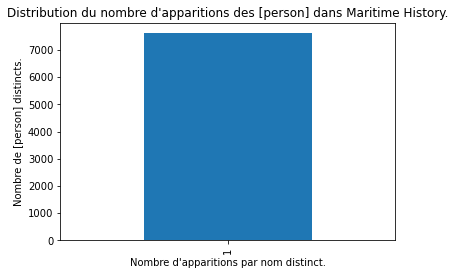

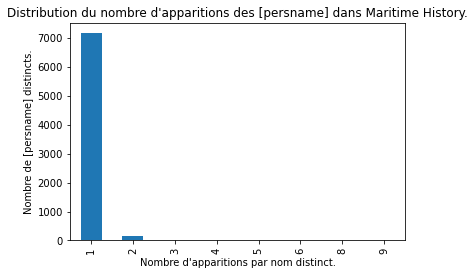

In [10]:
print(f"Voici les résultats de la requête surles personnes dans Maritime History :")
display(mh_people)

mh_p = sum_it_up(mh_people, "Maritime History", 'person')
mh_pl = sum_it_up(mh_people, "Maritime History", 'persname')

Voici les résultats de la requête sur les navires dans Maritime History :


,ship,ship_name
0,http://geovistory.org/resource/i179209,Rode Leeuw
1,http://geovistory.org/resource/i178150,Breedam
2,http://geovistory.org/resource/i179162,Purmerend
3,http://geovistory.org/resource/i179795,Schaapherder
4,http://geovistory.org/resource/i178915,Meervliet
...,...,...
1850,http://geovistory.org/resource/i179315,Snoek
1851,http://geovistory.org/resource/i179611,Weesp
1852,http://geovistory.org/resource/i179607,Watervliet
1853,http://geovistory.org/resource/i179640,Wieringen


Il y a 1855 lignes au tableau Maritime History, avec 1855 "ship" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,http://geovistory.org/resource/i177945,1
1,http://geovistory.org/resource/i177946,1
2,http://geovistory.org/resource/i177947,1
3,http://geovistory.org/resource/i177948,1
4,http://geovistory.org/resource/i177949,1
...,...,...
1850,http://geovistory.org/resource/i179795,1
1851,http://geovistory.org/resource/i179796,1
1852,http://geovistory.org/resource/i179797,1
1853,http://geovistory.org/resource/i179798,1


Extrait du tableau source du diagramme :


,how many distinct [ship],appear that often
0,1855,1


Comment lire ce diagramme : 1855 [ship] sont présents 1 fois.
Il y a 1855 lignes au tableau Maritime History, avec 1376 "ship_name" différents. Voici combien de fois chacun apparaît :


,name,appear that often
0,'s Heer Arendskerke,1
1,'s Lands Welvaren,1
2,'s-Graveland,2
3,'s-Gravenhage,1
4,'s-Gravenzande,1
...,...,...
1371,Zwemmer,1
1372,Zwolle,1
1373,l'Active,1
1374,l'Aigle Noir,1


Extrait du tableau source du diagramme :


,how many distinct [ship_name],appear that often
0,1078,1
1,207,2
2,53,3


Comment lire ce diagramme : 1078 [ship_name] sont présents 1 fois.


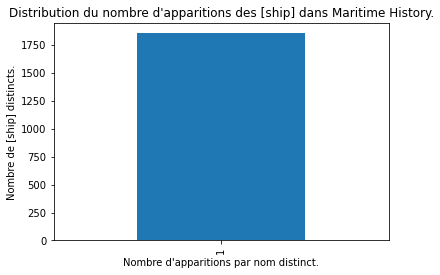

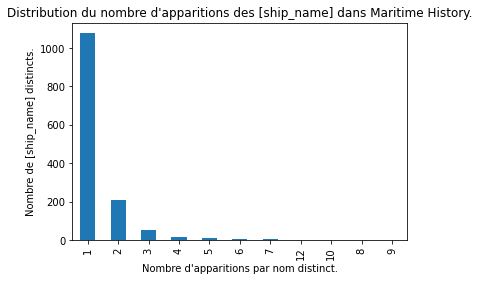

In [11]:
print(f"Voici les résultats de la requête sur les navires dans Maritime History :")
display(mh_ships)

mh_v = sum_it_up(mh_ships, "Maritime History", 'ship')
mh_vl = sum_it_up(mh_ships, "Maritime History", 'ship_name')

### Test transformations de noms

In [13]:
sv_mod = sv_orig

captains = []
alt_spelling = []

for captain in sv_mod['Captain\'s name']:
    
    if '(a)' in captain:
        alt_spelling.append(captain.split(' (a) ')[1])
    else:
        alt_spelling.append('')
    
    if ',' in captain:
        split_n = captain.split(' (a) ')[0].split(',')
        captains.append(split_n[1] + ' ' + split_n[0])
    else:
        captains.append(captain)

sv_mod["Reordered Captain's name respelled"] = captains
sv_mod["Original Captain's name"] = alt_spelling

sv_mod

,Flag of vessel,Date vessel departed with captives,Vessel name,Captain's name,Reordered Captain's name respelled,Original Captain's name
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter",Daniel ter Velde,
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der",Jan van der Hoeven,
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof",Roelof Wenman,
3,Netherlands,,Wapen van Amsterdam,,,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter",Pieter Scheij,
...,...,...,...,...,...,...
1904,Netherlands,,,"Broeke, Abraham van de",Abraham van de Broeke,
1905,Netherlands,,Jonge Mathijs,"Janssen, Carel",Carel Janssen,
1906,Netherlands,,Elisabeth Catharina,"Eversen, Huybrecht",Huybrecht Eversen,
1907,Netherlands,,,,,


In [16]:
corr_ships = []
alt_spelling = []

for ship in sv_mod['Vessel name']:
    
    if '(a)' in ship:
        alt_spelling.append(ship.split('(a)')[1])
        corr_ships.append(ship.split('(a)')[0])
    else:
        alt_spelling.append('')
        corr_ships.append('')
    
sv_mod["Vessel name corrected"] = corr_ships
sv_mod["Original Vessel name"] = alt_spelling

sv_mod

,Flag of vessel,Date vessel departed with captives,Vessel name,Captain's name,Reordered Captain's name respelled,Original Captain's name,Vessel name corrected,Original Vessel name
0,Netherlands,1732-09-03T00:00:00Z,Waartwijk,"Velde, Daniel ter",Daniel ter Velde,,,
1,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Hoeven, Jan van der",Jan van der Hoeven,,,
2,Netherlands,1706-09-09T00:00:00Z,Wakende Kraan,"Wenman, Roelof",Roelof Wenman,,,
3,Netherlands,,Wapen van Amsterdam,,,,,
4,Netherlands,,Wapen van Amsterdam,"Scheij, Pieter",Pieter Scheij,,,
...,...,...,...,...,...,...,...,...
1904,Netherlands,,,"Broeke, Abraham van de",Abraham van de Broeke,,,
1905,Netherlands,,Jonge Mathijs,"Janssen, Carel",Carel Janssen,,,
1906,Netherlands,,Elisabeth Catharina,"Eversen, Huybrecht",Huybrecht Eversen,,,
1907,Netherlands,,,,,,,


In [17]:
sv_mod.to_csv('netherlands_modded.csv')